# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [29]:
import pandas as pd
import seaborn as sns
from seaborn import load_dataset

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree

renda = pd.read_csv('previsao_de_renda.csv')
renda

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,2016-03-01,16006,F,False,True,0,Empresário,Secundário,Solteiro,Casa,48,13.887671,1.0,7990.58
14996,14996,2016-03-01,3722,F,False,True,0,Pensionista,Superior completo,Solteiro,Casa,57,NaN,1.0,10093.45
14997,14997,2016-03-01,6194,F,True,True,0,Assalariado,Superior completo,Casado,Casa,45,7.832877,2.0,604.82
14998,14998,2016-03-01,4922,M,True,False,0,Empresário,Superior completo,Casado,Casa,36,4.298630,2.0,3352.27


In [30]:
#Ajustando o DF
renda.drop(['Unnamed: 0','id_cliente'],axis = 1,inplace=True)
renda['tempo_emprego'].fillna(renda['tempo_emprego'].mean(),inplace=True)

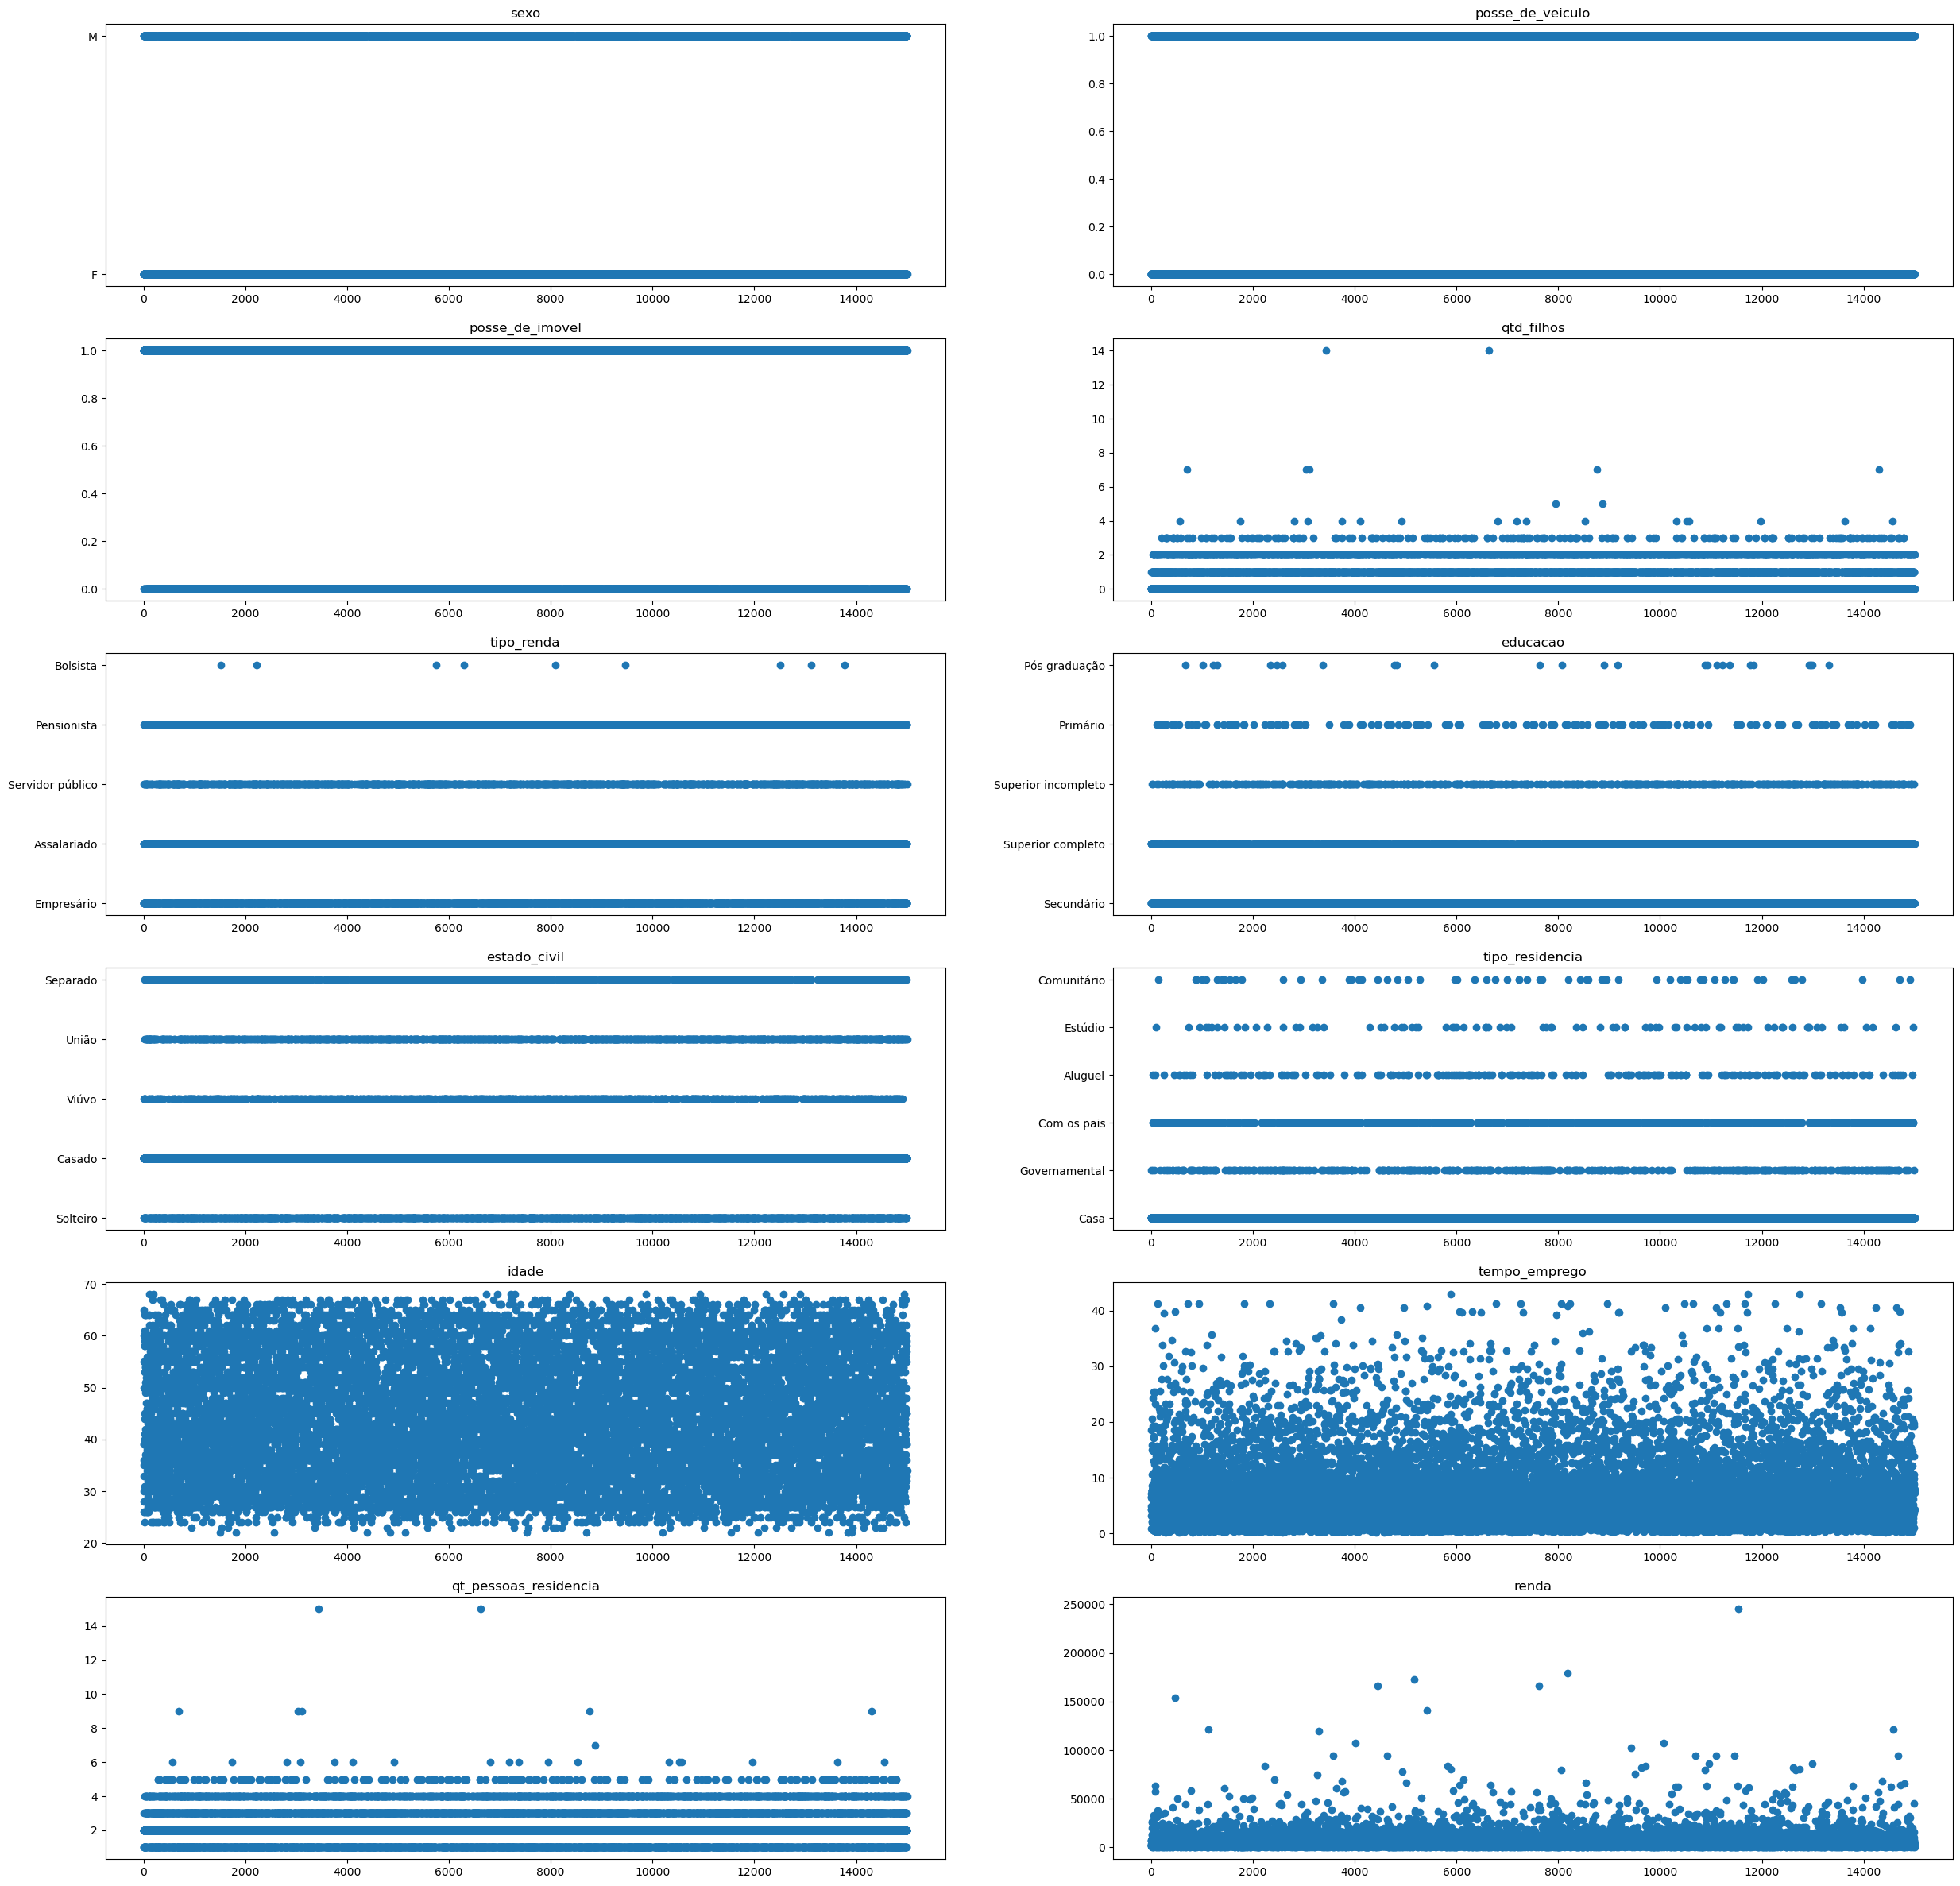

In [31]:
fig, axes = plt.subplots(nrows=((len(renda.columns)//2)), ncols=2, figsize=(30,30))
o = 0
b = 0
for i, col in enumerate(renda.drop('data_ref',axis = 1).columns):
        b = i//2
        axes[b,o].scatter(y = renda[col],x = renda.index)
        axes[b,o].set_title(col)
        if o == 0:
            o +=1
        else:
            o = 0
plt.show()

#agrupando qt_pessoas_residencia para uma melhor performance
bin_boundaries = [0, 1, 2, 4, float('inf')] 
bin_labels = ['1', '2', '3-4', '5+'] 
renda['qt_pessoas_residencia'] = pd.cut(renda['qt_pessoas_residencia'], bin_boundaries, labels=bin_labels)
renda.drop('data_ref',axis = 1,inplace = True)
train,test = train_test_split(renda,test_size=0.25,random_state=17)
#removendo outliers para o df de treino, rendas exorbitantes atrapalhariam a generalização do modelo
renda_train = train.loc[renda['renda'] < 50000]

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

R2 no log(y) :0.3247425328545387
0.24927915120682764


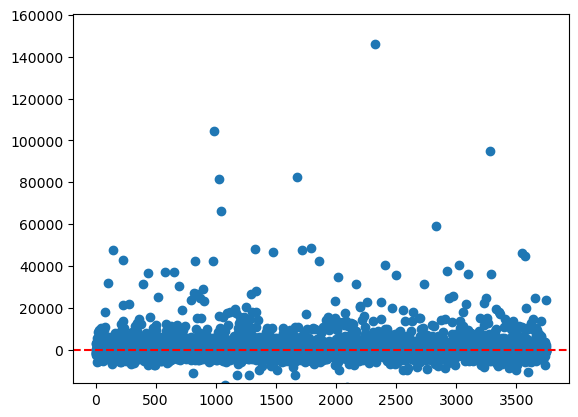

Residuos sem outliers, R2:0.28513679753849763


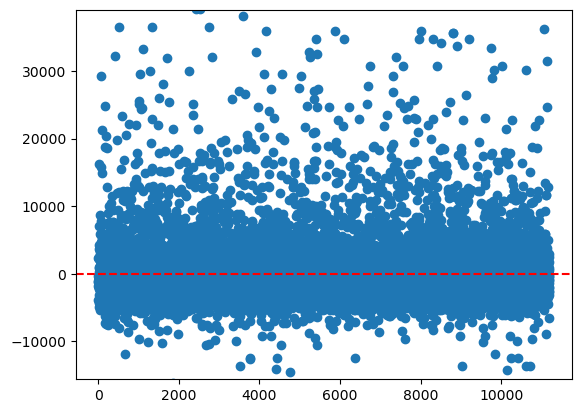

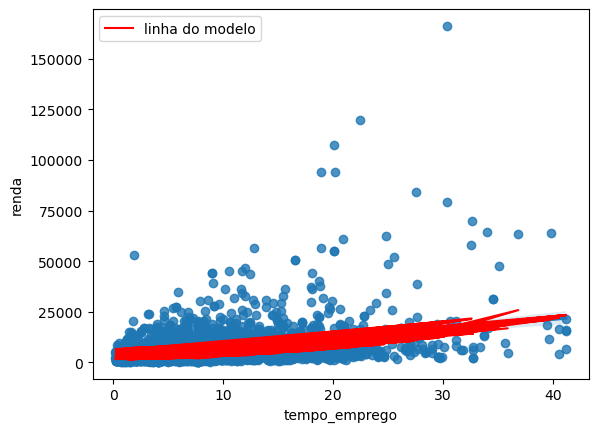

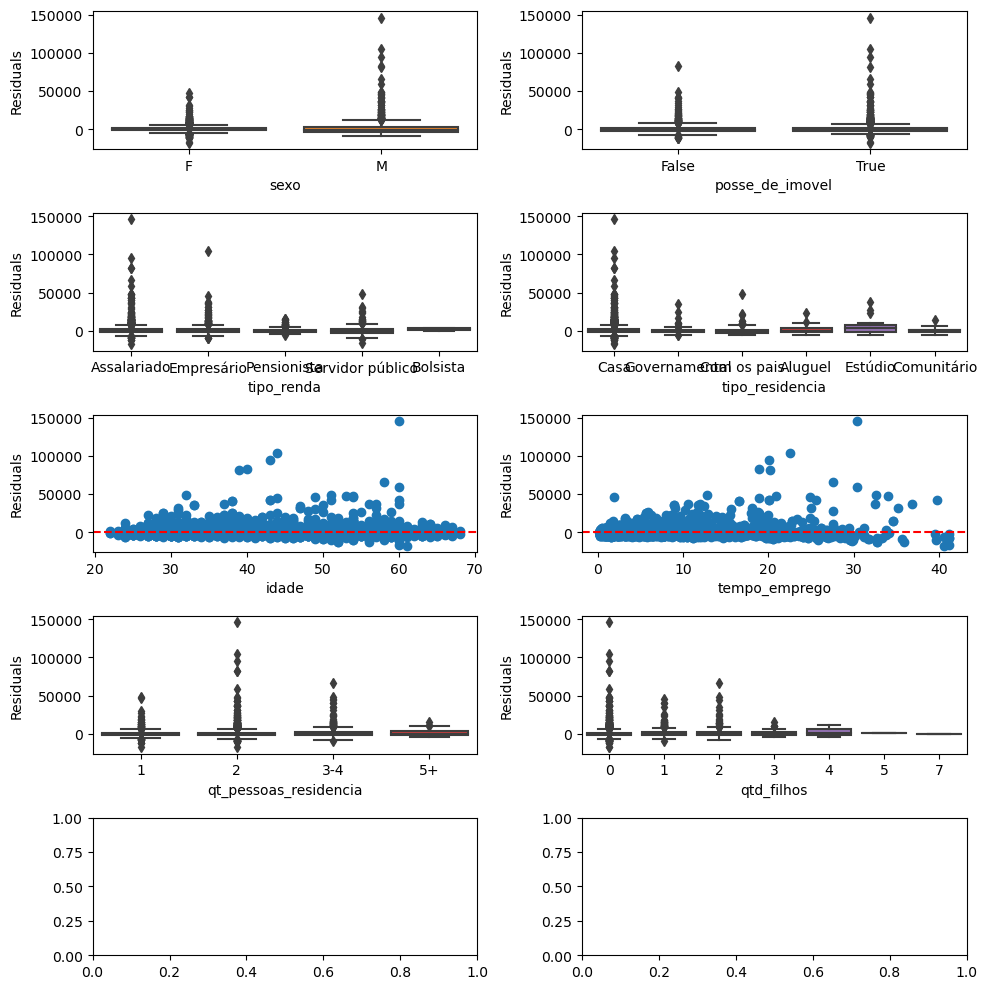

In [32]:
#ajustando os dados e removendo outliers
def op_y(y):
    return np.power(y,1/.6)

values = """np.power(renda,.6) ~  sexo + posse_de_imovel + tipo_renda + C(qt_pessoas_residencia,Treatment(1))  + idade + I(tempo_emprego + np.power(tempo_emprego,1.5))"""
y_train, X_train = patsy.dmatrices(values, renda_train)
y_test, X_test = patsy.dmatrices(values,test)
#colocando y_train no padrão da coluna apropriada
modelo = None
best_a = None
#treinando o modelo
for o in [0,1]:
    for a in [0, 0.001, 0.005, 0.01, 0.05, 0.1]:
        md = sm.OLS(y_train,X_train)
        md = md.fit_regularized(method='elastic_net',refit = True,L1_wt = o,alpha = a)
        y_pred = md.predict(X_test)
        #obtendo o residuo manualmente, alguma alternativa para se conseguir esses dados para os dados preditos?
        res = (np.ravel(y_test) - y_pred)
        res_t = res.sum()

        R2 = r2_score(np.ravel(y_test),y_pred)
        if best_a is None or best_a[0] < R2:
            best_a = [R2,a,o]
            modelo = md
print(f'R2 no log(y) :{best_a[0]}')
y_test = op_y(y_test)
y_pred = modelo.predict(X_test)

y_pred = op_y(y_pred)
y_train = op_y(y_train)

#obtendo o residuo manualmente, alguma alternativa para se conseguir esses dados para os dados preditos?
res = (np.ravel(y_test) - y_pred)
res_t = res.sum()

y_pred_m_trans = op_y(modelo.fittedvalues)
residuo_m_trans = np.ravel(y_train) - y_pred_m_trans

R2 = r2_score(np.ravel(y_test),y_pred)
R2_M = r2_score(np.ravel(y_train),y_pred_m_trans)


#plotando os residuos
plt.scatter(np.arange(len(res)),res)
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim(res.min() - (res.min()/10),res.max() + (res.max()/10))
print(R2)
plt.show()

#plotando residuos sem outliers
plt.scatter(np.arange(len(residuo_m_trans)),residuo_m_trans)
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim(residuo_m_trans.min() - 10*(residuo_m_trans.min()/100),residuo_m_trans.max() - 10*(residuo_m_trans.max()/100))
print(f'Residuos sem outliers, R2:{(R2_M)}')
plt.show()


#plotando o modelo
coluna = 'tempo_emprego'
sns.regplot(y = test['renda'], x = test[coluna])
x = test[coluna]
y = (y_pred)
plt.plot(x, y, '-r', label='linha do modelo')
plt.legend()
plt.show()
#residuos por coluna
column = ['sexo','posse_de_imovel','tipo_renda','tipo_residencia' ,'idade' , 'tempo_emprego','qt_pessoas_residencia','qtd_filhos']
fig, axes = plt.subplots(nrows=((len(column)//2)+ 1), ncols=2, figsize=(10, 10))
o = 0
b = 0
for i, col in enumerate(column):
    if len(test[col].value_counts()) > 20:
        b = i//2
        axes[b,o].scatter(x = test[col], y = res)
        axes[b,o].set_xlabel(col)
        axes[b,o].set_ylabel('Residuals')
        axes[b,o].axhline(y=0, color='r', linestyle='--')
        if o == 0:
            o +=1
        else:
            o = 0
    else:
        b = i//2
        sns.boxplot(x = test[col], y = res,ax = axes[b,o])
        axes[b,o].set_xlabel(col)
        axes[b,o].set_ylabel('Residuals')
        if o == 0:
            o +=1
        else:
            o = 0

plt.tight_layout()
plt.show()



In [33]:

renda_train = pd.get_dummies(renda_train).astype('float')
X_train = renda_train.drop('renda',axis = 1)
y_train = renda_train['renda']
X_test = pd.get_dummies(test.drop('renda',axis = 1))
y_test = test['renda']

print(X_train.columns)
print(X_test.columns)



Index(['posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'idade',
       'tempo_emprego', 'sexo_F', 'sexo_M', 'tipo_renda_Assalariado',
       'tipo_renda_Bolsista', 'tipo_renda_Empresário',
       'tipo_renda_Pensionista', 'tipo_renda_Servidor público',
       'educacao_Primário', 'educacao_Pós graduação', 'educacao_Secundário',
       'educacao_Superior completo', 'educacao_Superior incompleto',
       'estado_civil_Casado', 'estado_civil_Separado', 'estado_civil_Solteiro',
       'estado_civil_União', 'estado_civil_Viúvo', 'tipo_residencia_Aluguel',
       'tipo_residencia_Casa', 'tipo_residencia_Com os pais',
       'tipo_residencia_Comunitário', 'tipo_residencia_Estúdio',
       'tipo_residencia_Governamental', 'qt_pessoas_residencia_1',
       'qt_pessoas_residencia_2', 'qt_pessoas_residencia_3-4',
       'qt_pessoas_residencia_5+'],
      dtype='object')
Index(['posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'idade',
       'tempo_emprego', 'sexo_F', 'sexo_M', 'tipo_rend

In [34]:

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            print(included+[new_column])
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        print(included)
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


In [35]:
#não esta rodando
#variaveis = stepwise_selection(X,y)
#print(variaveis)
#reg_stepwise = sm.OLS(y, sm.add_constant(pd.DataFrame(X[variaveis]))).fit()
#reg_stepwise.summary()

In [36]:
tree_dict= {}
for s in range(5,25):
    for depth in range(2,9):
        rt = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=s,random_state=17)
        rt.fit(X_train,y_train)
        
        tree_dict[f"tree_depth{depth} - {s}"] = rt


best = None
for key,rt in tree_dict.items():
    test = rt.predict(X_test)
    mse = np.mean((test - y_test) ** 2)
    if best == None or best[0] > mse:
        best = [mse,rt]
    
print(f'{str(best[1])} : MSE é {best[0]}')

DecisionTreeRegressor(max_depth=8, min_samples_leaf=8, random_state=17) : MSE é 38284912.9643989


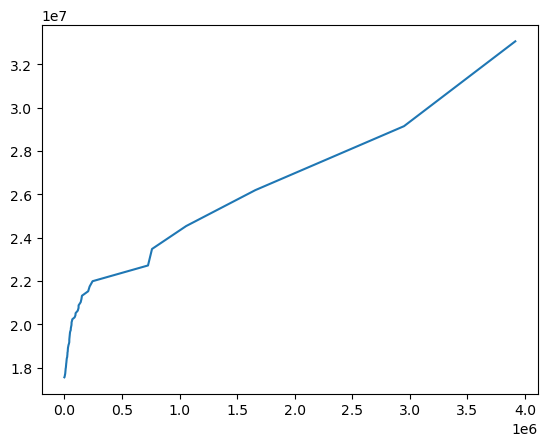

In [37]:
path = best[1].cost_complexity_pruning_path(X_train,y_train)
ccp_alphas , impurities = path.ccp_alphas, path.impurities

plt.plot(ccp_alphas,impurities)

In [38]:
trees = []
for alpha in ccp_alphas:
    rt = DecisionTreeRegressor(random_state = 17, ccp_alpha=alpha)
    rt.fit(X_train,y_train)
    trees.append(rt)

In [39]:
mse = [mean_squared_error(y_test,rt.predict(X_test)) for rt in trees]
mse_t = [mean_squared_error(y_train,rt.predict(X_train)) for rt in trees]

#alpha minimum  mse value
min_value = min(mse)
min_index = mse.index(min_value)
min_a = ccp_alphas[min_index]

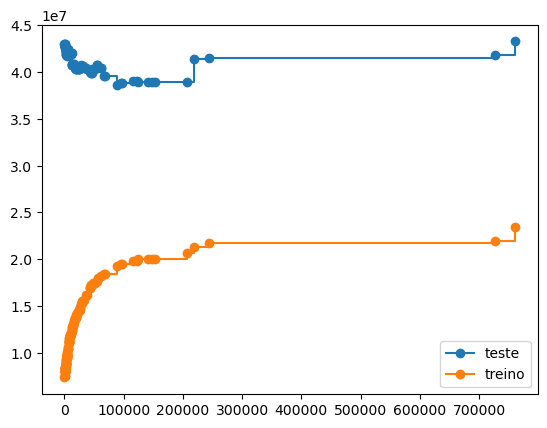

array([0.00000000e+00, 2.15795526e+02, 2.61116144e+02, 8.03955406e+02,
       8.23966706e+02, 8.48513658e+02, 8.97746373e+02, 9.60922561e+02,
       1.04052783e+03, 1.15179515e+03, 1.16959246e+03, 1.29618118e+03,
       1.45039188e+03, 1.47343834e+03, 1.63981145e+03, 1.66444572e+03,
       1.85743479e+03, 1.98189503e+03, 2.04716154e+03, 2.28791280e+03,
       2.28816438e+03, 2.37864222e+03, 2.42543470e+03, 2.52078736e+03,
       2.60127726e+03, 2.69905315e+03, 3.12371451e+03, 3.17760447e+03,
       3.43425410e+03, 3.67576151e+03, 3.82371853e+03, 3.83406188e+03,
       3.85234393e+03, 3.95174653e+03, 4.22074907e+03, 4.30924961e+03,
       4.53014238e+03, 4.59784693e+03, 4.66571028e+03, 4.72649508e+03,
       4.85458376e+03, 5.18815880e+03, 5.96037274e+03, 5.97911531e+03,
       6.09701609e+03, 6.49223853e+03, 7.01357138e+03, 7.43315377e+03,
       7.48746613e+03, 7.66353441e+03, 7.84022201e+03, 7.94188806e+03,
       8.23049347e+03, 8.51534742e+03, 9.12719763e+03, 9.42095211e+03,
      

In [40]:
fig, ax = plt.subplots()
ax.set_xlabel = 'alpha'
ax.set_ylabel = 'mse'
ax.plot(ccp_alphas[:-4],mse[:-4],marker = 'o',label = 'teste',drawstyle = 'steps-post')
ax.plot(ccp_alphas[:-4],mse_t[:-4],marker = 'o',label = 'treino',drawstyle = 'steps-post')

ax.legend()

plt.show()
ccp_alphas

In [41]:
rt = DecisionTreeRegressor(ccp_alpha=min_a)
rt.fit(X_train,y_train)
y_pred = rt.predict(X_test)

res = y_pred - y_test
ss_res = np.sum(res ** 2)
total = np.sum((y_test - np.mean(y_test))**2)

R_squared = 1 - (ss_res / total)
R_squared

0.3691645043988515

Essa arvore ficou o melhor modelo, apos a reduçao de complexidade o R2 passou de 38 para 36 mas sendo um modelo muito menos complexo.

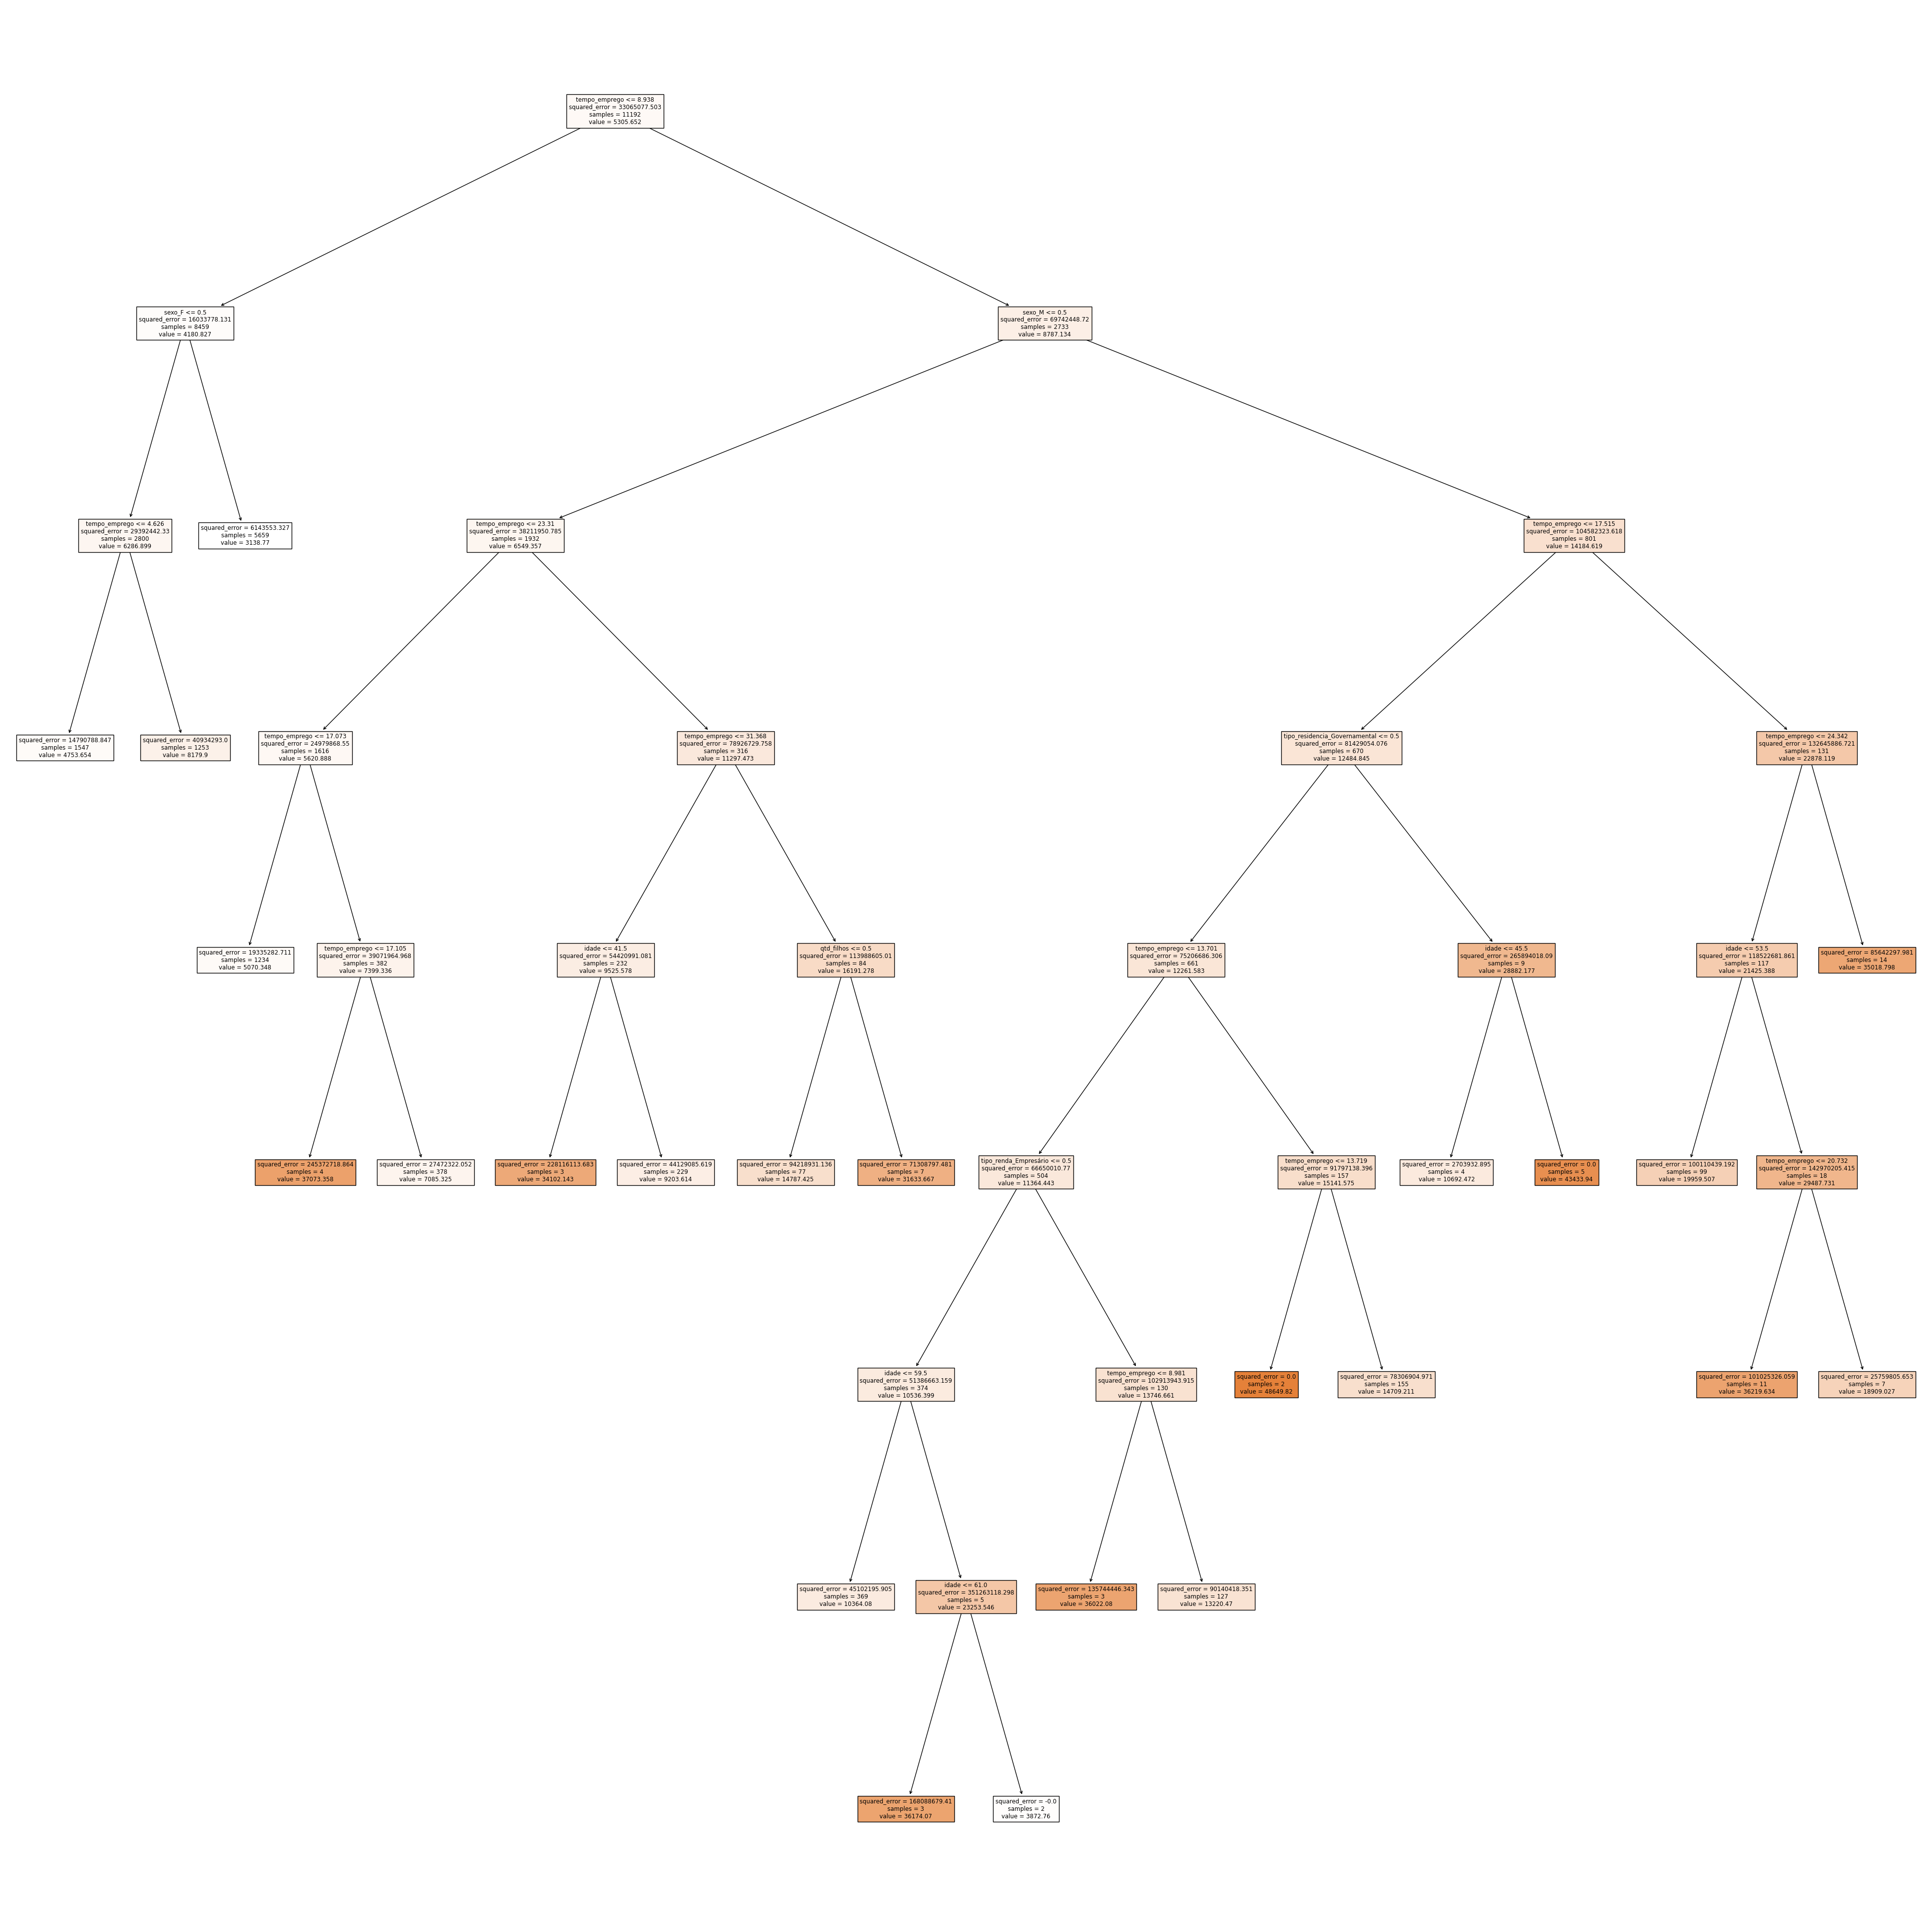

In [42]:
fig, ax = plt.subplots(figsize=(50, 50))
plot_tree(rt,filled=True,ax=ax,feature_names=X_train.columns)
plt.show()